In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
import itertools
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [3]:
predict_train = pd.read_csv("train_csv.csv")

In [4]:
predict_train.head()

,id,time,feature
0,0,2019-03-19 00:00:00,237.97
1,1,2019-03-19 00:00:10,57.93
2,2,2019-03-19 00:00:20,90.53
3,3,2019-03-19 00:00:30,260.75
4,4,2019-03-19 00:00:40,49.70


In [23]:
import seaborn as sns
sns.set(rc={'figure.figsize':(11, 4)})

In [24]:
predict_train.drop(['id'],axis = 1,inplace = True)

In [25]:
predict_train['time'] = pd.to_datetime(predict_train['time'])

In [26]:
predict_train.dtypes

time       datetime64[ns]
feature           float64
dtype: object

In [28]:
predict_train.head()

,time,feature
0,2019-03-19 00:00:00,237.97
1,2019-03-19 00:00:10,57.93
2,2019-03-19 00:00:20,90.53
3,2019-03-19 00:00:30,260.75
4,2019-03-19 00:00:40,49.70


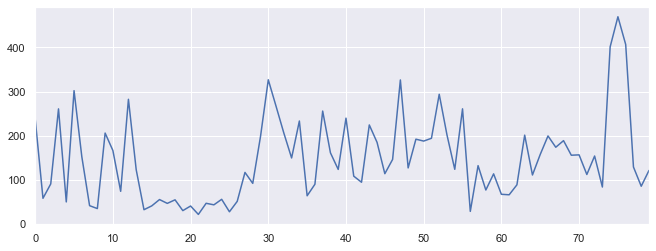

In [29]:
predict_train['feature'].plot(grid=True)

# To check if there exists a correlation between data points

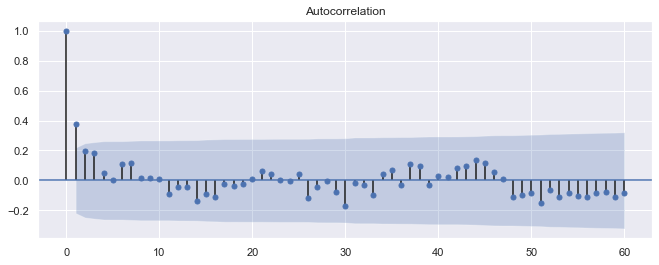

In [32]:
plot_acf(predict_train['feature'],lags=60)
pyplot.show()

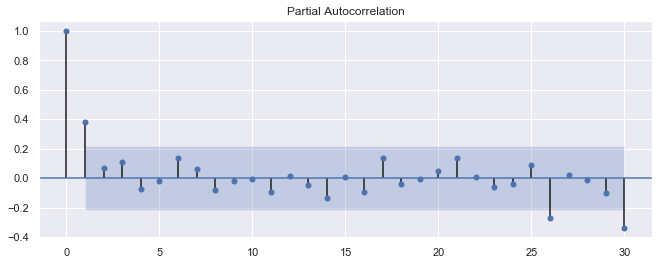

In [35]:
plot_pacf(predict_train['feature'], lags=30)
pyplot.show()

In [19]:
# with the ACF and PACF graph, we can conclude that the given Time Series is Non-Stationary.

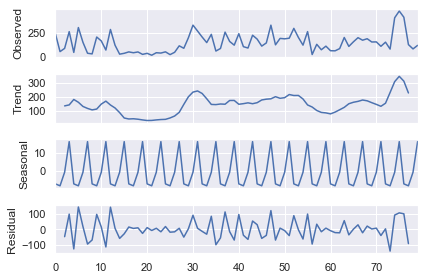

In [39]:
decompPred = sm.tsa.seasonal_decompose(predict_train.feature, model="additive", freq=4)
decompPred.plot()
plt.show()

In [40]:
train_split = predict_train[0:int(len(predict_train)*0.7)] 
test_split = predict_train[int(len(predict_train)*0.7):]

In [44]:
# We cannot use Linear Regression model as data has single dependent variable.
# We'll go with ARIMA model - Autoregressive Integrated Moving Average,is a forecasting method for univariate time series data.

In [45]:
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

In [58]:
feature_train =  train_split['feature']
feature_test =  test_split['feature']

In [82]:
for param in pdq:
    model = ARIMA(feature_train, order=param)
    results = model.fit(disp=0)
    print('ARIMA{} - AIC:{}'.format(param, results.aic))

ARIMA(0, 0, 0) - AIC:665.9868749383882
ARIMA(0, 0, 1) - AIC:663.8145191436821
ARIMA(0, 1, 0) - AIC:673.166923441716
ARIMA(0, 1, 1) - AIC:650.8740102002349
ARIMA(1, 0, 0) - AIC:663.2335809561273
ARIMA(1, 0, 1) - AIC:661.001395567137
ARIMA(1, 1, 0) - AIC:664.0215724142131
ARIMA(1, 1, 1) - AIC:652.869919895173


In [60]:
# From the above output data, we can see the param(0,1,1) has less AIC value, so it can be considered as a optimum param

In [109]:
model = ARIMA(feature_train, order=(0,1,1))
results = model.fit()
print(results.summary())

                             ARIMA Model Results                              
Dep. Variable:              D.feature   No. Observations:                   55
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -322.437
Method:                       css-mle   S.D. of innovations             84.413
Date:                Fri, 12 Jun 2020   AIC                            650.874
Time:                        15:56:55   BIC                            656.896
Sample:                             1   HQIC                           653.203
                                                                              
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               1.1227      2.908      0.386      0.701      -4.577       6.823
ma.L1.D.feature    -0.7599      0.101     -7.540      0.000      -0.957      -0.562
                                

In [120]:
predictions = list()
for t in range(len(feature_test)):
    model = ARIMA(feature_train, order=(0,1,1))
    model_fit = model.fit()
    output = model_fit.forecast(steps=1)
    yhat = output[0]
    predictions.append(yhat)
error = np.sqrt(mean_squared_error(feature_test, predictions))
print('Test RMSE: %.3f' % error)

Test RMSE: 120.060


In [101]:
predict_test = pd.read_csv("test_csv.csv")
predict_test.head()

,id,time
0,80,2019-03-19 00:13:20
1,81,2019-03-19 00:13:30
2,82,2019-03-19 00:13:40
3,83,2019-03-19 00:13:50
4,84,2019-03-19 00:14:00


In [126]:
forecast = results.forecast(steps=40)[0]
predict_test['forecast'] = forecast
predict_test.head()

,id,time,forecast
0,80,2019-03-19 00:13:20,210.730201
1,81,2019-03-19 00:13:30,211.852930
2,82,2019-03-19 00:13:40,212.975660
3,83,2019-03-19 00:13:50,214.098389
4,84,2019-03-19 00:14:00,215.221118
